In [24]:
# 04c - Régression Transfer learning
# Régression partir d'un modèle VGG16 déjà entraîné

In [2]:
# Définitions globales
HOME = '/Users/u600141/OneDrive - La Francaise des Jeux/Data/constructions/'

# Si RGB
PATHS_BDORTHO_PICKLE = HOME + 'images/BDORTHO_RGB/pickle/'
# Si IRC
#PATHS_BDORTHO_PICKLE = HOME + 'images/BDORTHO_IRC/pickle/'

IMAGE_SIZE = (512, 512)
BATCH_SIZE = 16
SEED = 123


In [1]:
# Imports
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import cv2
import dr

In [3]:
# Imports Deep learning
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D,GlobalAveragePooling2D,Dropout, Flatten, Dense, LeakyReLU
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.saving import load_model
from keras.models import Model
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from PIL import Image 
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import os
from tensorflow.keras.optimizers.legacy import Adam #.legacy pour cause de ralentissement sur Mac M1

# VGG 16
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [4]:
# Chargement des méta-données BDORTHO
dfi = pd.read_pickle(PATHS_BDORTHO_PICKLE + 'dfi.pkl')
print (f'dfi chargé, taille : {len(dfi)}')

dfi chargé, taille : 11875


In [5]:
# Séparation du jeu de données
# On garde 10% en validation finale (80% train et 20% test sur les 90% restant) 
df_test = dfi[(dfi.index % 10) == 0].reset_index()
df_train, df_valid = train_test_split(dfi[(dfi.index % 10) != 0], test_size=0.2, random_state=SEED)

print (f'Lignes df_train : {len(df_train)} ({len(df_train)/len(dfi)*100:.0f} %)')
print (f'Lignes df_valid : {len(df_valid)} ({len(df_valid)/len(dfi)*100:.0f} %)')
print (f'Lignes df_test  : {len(df_test)} ({len(df_test)/len(dfi)*100:.0f} %)')

Lignes df_train : 8549 (72 %)
Lignes df_valid : 2138 (18 %)
Lignes df_test  : 1188 (10 %)


In [6]:
# Définition des générateurs et flux

def preprocess_image(img):
    img = tf.cast(img, tf.float32) / 255.0
    return img

# TRAIN
image_train_datagen = ImageDataGenerator(horizontal_flip=True,
                                    vertical_flip=True,
                                    width_shift_range=5,
                                    height_shift_range=5,
                                    fill_mode='nearest',
                                    preprocessing_function=preprocess_image)

image_train_generator = image_train_datagen.flow_from_dataframe(dataframe=df_train,
                                                 x_col='filename', y_col='NumberOfPolygons',
                                                 target_size=IMAGE_SIZE,
                                                 batch_size=BATCH_SIZE,
                                                 seed=SEED,
                                                 class_mode='raw')

# VALID
image_valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_image)

image_valid_generator = image_valid_datagen.flow_from_dataframe(dataframe=df_valid,
                                                 x_col='filename', y_col='NumberOfPolygons',
                                                 target_size=IMAGE_SIZE,
                                                 batch_size=BATCH_SIZE,
                                                 seed=SEED,
                                                 shuffle=False,
                                                 class_mode='raw')

# TEST
image_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_image)

image_test_generator = image_test_datagen.flow_from_dataframe(dataframe=df_test,
                                                 x_col='filename', y_col='NumberOfPolygons',
                                                 target_size=IMAGE_SIZE,
                                                 batch_size=BATCH_SIZE,
                                                 seed=SEED,
                                                 shuffle=False,
                                                 class_mode='raw')



Found 8549 validated image filenames.
Found 2138 validated image filenames.
Found 1188 validated image filenames.


In [56]:
# Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback, ModelCheckpoint
from timeit import default_timer as timer

class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

model_checkpoint = ModelCheckpoint(
    filepath=dr.makeFileNameRoot('models/model transfer2'),
    monitor='val_mean_absolute_error',
    mode='min',
    save_best_only=True,
    verbose=1)

early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0.01, patience=10, mode='min', verbose=1)
reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss',
                                         min_delta=0.01, patience=6, factor=0.1,
                                         cooldown=4, verbose=1)
time_callback = TimingCallback()


In [53]:
# Modèle

inputs = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), name='Input')

# Modèle VGG16 avec freeze des couches pré-entraînées
base_model = VGG16(weights='./vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False)
for layer in base_model.layers:
    layer.trainable = False

# Ajout des couches finales
dropout_1 = Dropout(rate=0.5, name='Dropout_1')
globalaveragepooling2D_1 = GlobalAveragePooling2D(name='GlobalAveragePooling2D_1')
dense_1 = Dense(units=256, activation=LeakyReLU(0.01), name='Dense_1')
dense_2 = Dense(units=1, activation='linear', name='Dense_2')

x = base_model(inputs)
x = dropout_1(x)
x = globalaveragepooling2D_1(x)
x = dense_1(x)
outputs = dense_2(x)

model = Model(inputs = inputs, outputs = outputs)
model.compile(loss='mse',
              optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-3),
              metrics=['mean_absolute_error'])
model.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 512, 512, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 Dropout_1 (Dropout)         (None, 16, 16, 512)       0         
                                                                 
 GlobalAveragePooling2D_1 (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 Dense_1 (Dense)             (None, 256)               131328    
                                                                 
 Dense_2 (Dense)             (None, 1)                 257       
                                                           

In [54]:
# Entraînement et sauvegarde du modèle
model_history = model.fit(image_train_generator,
                                epochs=100,
                                steps_per_epoch=len(image_train_generator),
                                callbacks=[model_checkpoint, early_stopping, reduce_learning_rate, time_callback],
                                validation_data = image_valid_generator,
                                validation_steps= len(image_valid_generator),
                                verbose=True)

model.save('model_vgg16')

Epoch 1/100
535/535 [==============================] - ETA: 0s - loss: 1239.6323 - mean_absolute_error: 24.5748
Epoch 1: val_mean_absolute_error improved from inf to 14.75534, saving model to models/model transfer_202403011547
INFO:tensorflow:Assets written to: models/model transfer_202403011547/assets


INFO:tensorflow:Assets written to: models/model transfer_202403011547/assets


535/535 [==============================] - 684s 1s/step - loss: 1239.6323 - mean_absolute_error: 24.5748 - val_loss: 484.0863 - val_mean_absolute_error: 14.7553 - lr: 0.0010
Epoch 2/100
535/535 [==============================] - ETA: 0s - loss: 428.7080 - mean_absolute_error: 13.7729
Epoch 2: val_mean_absolute_error improved from 14.75534 to 13.90863, saving model to models/model transfer_202403011547
INFO:tensorflow:Assets written to: models/model transfer_202403011547/assets


INFO:tensorflow:Assets written to: models/model transfer_202403011547/assets


535/535 [==============================] - 658s 1s/step - loss: 428.7080 - mean_absolute_error: 13.7729 - val_loss: 409.1637 - val_mean_absolute_error: 13.9086 - lr: 0.0010
Epoch 3/100
535/535 [==============================] - ETA: 0s - loss: 373.1961 - mean_absolute_error: 12.6779
Epoch 3: val_mean_absolute_error improved from 13.90863 to 12.63186, saving model to models/model transfer_202403011547
INFO:tensorflow:Assets written to: models/model transfer_202403011547/assets


INFO:tensorflow:Assets written to: models/model transfer_202403011547/assets


535/535 [==============================] - 659s 1s/step - loss: 373.1961 - mean_absolute_error: 12.6779 - val_loss: 372.0603 - val_mean_absolute_error: 12.6319 - lr: 0.0010
Epoch 4/100
535/535 [==============================] - ETA: 0s - loss: 349.5360 - mean_absolute_error: 12.0876
Epoch 4: val_mean_absolute_error improved from 12.63186 to 12.21465, saving model to models/model transfer_202403011547
INFO:tensorflow:Assets written to: models/model transfer_202403011547/assets


INFO:tensorflow:Assets written to: models/model transfer_202403011547/assets


535/535 [==============================] - 648s 1s/step - loss: 349.5360 - mean_absolute_error: 12.0876 - val_loss: 359.7193 - val_mean_absolute_error: 12.2147 - lr: 0.0010
Epoch 5/100
535/535 [==============================] - ETA: 0s - loss: 338.5150 - mean_absolute_error: 11.9361
Epoch 5: val_mean_absolute_error improved from 12.21465 to 11.93668, saving model to models/model transfer_202403011547
INFO:tensorflow:Assets written to: models/model transfer_202403011547/assets


INFO:tensorflow:Assets written to: models/model transfer_202403011547/assets


535/535 [==============================] - 677s 1s/step - loss: 338.5150 - mean_absolute_error: 11.9361 - val_loss: 344.4096 - val_mean_absolute_error: 11.9367 - lr: 0.0010
Epoch 6/100
535/535 [==============================] - ETA: 0s - loss: 326.4093 - mean_absolute_error: 11.7296
Epoch 6: val_mean_absolute_error improved from 11.93668 to 11.82229, saving model to models/model transfer_202403011547
INFO:tensorflow:Assets written to: models/model transfer_202403011547/assets


INFO:tensorflow:Assets written to: models/model transfer_202403011547/assets


535/535 [==============================] - 683s 1s/step - loss: 326.4093 - mean_absolute_error: 11.7296 - val_loss: 338.2528 - val_mean_absolute_error: 11.8223 - lr: 0.0010
Epoch 7/100
535/535 [==============================] - ETA: 0s - loss: 317.3496 - mean_absolute_error: 11.4993
Epoch 7: val_mean_absolute_error improved from 11.82229 to 11.77441, saving model to models/model transfer_202403011547
INFO:tensorflow:Assets written to: models/model transfer_202403011547/assets


INFO:tensorflow:Assets written to: models/model transfer_202403011547/assets


535/535 [==============================] - 657s 1s/step - loss: 317.3496 - mean_absolute_error: 11.4993 - val_loss: 330.8210 - val_mean_absolute_error: 11.7744 - lr: 0.0010
Epoch 8/100
535/535 [==============================] - ETA: 0s - loss: 320.3414 - mean_absolute_error: 11.5652
Epoch 8: val_mean_absolute_error improved from 11.77441 to 11.54653, saving model to models/model transfer_202403011547
INFO:tensorflow:Assets written to: models/model transfer_202403011547/assets


INFO:tensorflow:Assets written to: models/model transfer_202403011547/assets


535/535 [==============================] - 633s 1s/step - loss: 320.3414 - mean_absolute_error: 11.5652 - val_loss: 324.6706 - val_mean_absolute_error: 11.5465 - lr: 0.0010
Epoch 9/100
535/535 [==============================] - ETA: 0s - loss: 312.2416 - mean_absolute_error: 11.4108
Epoch 9: val_mean_absolute_error did not improve from 11.54653
535/535 [==============================] - 636s 1s/step - loss: 312.2416 - mean_absolute_error: 11.4108 - val_loss: 324.0325 - val_mean_absolute_error: 11.6800 - lr: 0.0010
Epoch 10/100
535/535 [==============================] - ETA: 0s - loss: 309.5754 - mean_absolute_error: 11.2849
Epoch 10: val_mean_absolute_error improved from 11.54653 to 11.49758, saving model to models/model transfer_202403011547
INFO:tensorflow:Assets written to: models/model transfer_202403011547/assets


INFO:tensorflow:Assets written to: models/model transfer_202403011547/assets


535/535 [==============================] - 662s 1s/step - loss: 309.5754 - mean_absolute_error: 11.2849 - val_loss: 319.8619 - val_mean_absolute_error: 11.4976 - lr: 0.0010
Epoch 11/100
535/535 [==============================] - ETA: 0s - loss: 307.0278 - mean_absolute_error: 11.2630
Epoch 11: val_mean_absolute_error did not improve from 11.49758
535/535 [==============================] - 649s 1s/step - loss: 307.0278 - mean_absolute_error: 11.2630 - val_loss: 334.3241 - val_mean_absolute_error: 11.6950 - lr: 0.0010
Epoch 12/100
535/535 [==============================] - ETA: 0s - loss: 301.6679 - mean_absolute_error: 11.1435
Epoch 12: val_mean_absolute_error did not improve from 11.49758
535/535 [==============================] - 639s 1s/step - loss: 301.6679 - mean_absolute_error: 11.1435 - val_loss: 317.1819 - val_mean_absolute_error: 11.5221 - lr: 0.0010
Epoch 13/100
535/535 [==============================] - ETA: 0s - loss: 300.0442 - mean_absolute_error: 11.2234
Epoch 13: val_mea

INFO:tensorflow:Assets written to: models/model transfer_202403011547/assets


535/535 [==============================] - 635s 1s/step - loss: 300.0442 - mean_absolute_error: 11.2234 - val_loss: 310.6498 - val_mean_absolute_error: 11.3423 - lr: 0.0010
Epoch 14/100
535/535 [==============================] - ETA: 0s - loss: 300.2022 - mean_absolute_error: 11.1223
Epoch 14: val_mean_absolute_error did not improve from 11.34231
535/535 [==============================] - 648s 1s/step - loss: 300.2022 - mean_absolute_error: 11.1223 - val_loss: 308.0898 - val_mean_absolute_error: 11.3581 - lr: 0.0010
Epoch 15/100
535/535 [==============================] - ETA: 0s - loss: 298.6154 - mean_absolute_error: 11.0603
Epoch 15: val_mean_absolute_error did not improve from 11.34231
535/535 [==============================] - 633s 1s/step - loss: 298.6154 - mean_absolute_error: 11.0603 - val_loss: 332.9830 - val_mean_absolute_error: 11.8719 - lr: 0.0010
Epoch 16/100
535/535 [==============================] - ETA: 0s - loss: 293.2040 - mean_absolute_error: 10.9440
Epoch 16: val_mea

INFO:tensorflow:Assets written to: models/model transfer_202403011547/assets


535/535 [==============================] - 644s 1s/step - loss: 293.2040 - mean_absolute_error: 10.9440 - val_loss: 302.1963 - val_mean_absolute_error: 11.2201 - lr: 0.0010
Epoch 17/100
535/535 [==============================] - ETA: 0s - loss: 291.2164 - mean_absolute_error: 10.9798
Epoch 17: val_mean_absolute_error did not improve from 11.22014
535/535 [==============================] - 689s 1s/step - loss: 291.2164 - mean_absolute_error: 10.9798 - val_loss: 302.8580 - val_mean_absolute_error: 11.3188 - lr: 0.0010
Epoch 18/100
535/535 [==============================] - ETA: 0s - loss: 288.9926 - mean_absolute_error: 10.9423
Epoch 18: val_mean_absolute_error did not improve from 11.22014
535/535 [==============================] - 647s 1s/step - loss: 288.9926 - mean_absolute_error: 10.9423 - val_loss: 301.1412 - val_mean_absolute_error: 11.4306 - lr: 0.0010
Epoch 19/100
535/535 [==============================] - ETA: 0s - loss: 286.7140 - mean_absolute_error: 10.9086
Epoch 19: val_mea

INFO:tensorflow:Assets written to: models/model transfer_202403011547/assets


535/535 [==============================] - 662s 1s/step - loss: 291.3240 - mean_absolute_error: 11.0482 - val_loss: 295.7898 - val_mean_absolute_error: 10.9405 - lr: 0.0010
Epoch 21/100
535/535 [==============================] - ETA: 0s - loss: 280.8657 - mean_absolute_error: 10.7520
Epoch 21: val_mean_absolute_error did not improve from 10.94045
535/535 [==============================] - 647s 1s/step - loss: 280.8657 - mean_absolute_error: 10.7520 - val_loss: 325.0016 - val_mean_absolute_error: 11.5724 - lr: 0.0010
Epoch 22/100
535/535 [==============================] - ETA: 0s - loss: 281.8470 - mean_absolute_error: 10.7775
Epoch 22: val_mean_absolute_error did not improve from 10.94045
535/535 [==============================] - 662s 1s/step - loss: 281.8470 - mean_absolute_error: 10.7775 - val_loss: 335.9259 - val_mean_absolute_error: 12.5047 - lr: 0.0010
Epoch 23/100
535/535 [==============================] - ETA: 0s - loss: 284.8207 - mean_absolute_error: 10.8547
Epoch 23: val_mea

INFO:tensorflow:Assets written to: models/model transfer_202403011547/assets


535/535 [==============================] - 647s 1s/step - loss: 281.5400 - mean_absolute_error: 10.8080 - val_loss: 286.8343 - val_mean_absolute_error: 10.8305 - lr: 0.0010
Epoch 25/100
535/535 [==============================] - ETA: 0s - loss: 280.3546 - mean_absolute_error: 10.8296
Epoch 25: val_mean_absolute_error did not improve from 10.83047
535/535 [==============================] - 641s 1s/step - loss: 280.3546 - mean_absolute_error: 10.8296 - val_loss: 299.5420 - val_mean_absolute_error: 11.1616 - lr: 0.0010
Epoch 26/100
535/535 [==============================] - ETA: 0s - loss: 277.6049 - mean_absolute_error: 10.7186
Epoch 26: val_mean_absolute_error did not improve from 10.83047
535/535 [==============================] - 640s 1s/step - loss: 277.6049 - mean_absolute_error: 10.7186 - val_loss: 289.1490 - val_mean_absolute_error: 11.1559 - lr: 0.0010
Epoch 27/100
535/535 [==============================] - ETA: 0s - loss: 277.0138 - mean_absolute_error: 10.7541
Epoch 27: val_mea

INFO:tensorflow:Assets written to: models/model transfer_202403011547/assets


535/535 [==============================] - 662s 1s/step - loss: 278.2634 - mean_absolute_error: 10.7850 - val_loss: 284.5552 - val_mean_absolute_error: 10.7830 - lr: 0.0010
Epoch 29/100
535/535 [==============================] - ETA: 0s - loss: 278.1084 - mean_absolute_error: 10.7688
Epoch 29: val_mean_absolute_error improved from 10.78300 to 10.77976, saving model to models/model transfer_202403011547
INFO:tensorflow:Assets written to: models/model transfer_202403011547/assets


INFO:tensorflow:Assets written to: models/model transfer_202403011547/assets


535/535 [==============================] - 674s 1s/step - loss: 278.1084 - mean_absolute_error: 10.7688 - val_loss: 282.2692 - val_mean_absolute_error: 10.7798 - lr: 0.0010
Epoch 30/100
535/535 [==============================] - ETA: 0s - loss: 276.4590 - mean_absolute_error: 10.6678
Epoch 30: val_mean_absolute_error did not improve from 10.77976
535/535 [==============================] - 645s 1s/step - loss: 276.4590 - mean_absolute_error: 10.6678 - val_loss: 288.2104 - val_mean_absolute_error: 10.9556 - lr: 0.0010
Epoch 31/100
535/535 [==============================] - ETA: 0s - loss: 276.6624 - mean_absolute_error: 10.7218
Epoch 31: val_mean_absolute_error did not improve from 10.77976
535/535 [==============================] - 646s 1s/step - loss: 276.6624 - mean_absolute_error: 10.7218 - val_loss: 283.4084 - val_mean_absolute_error: 10.8378 - lr: 0.0010
Epoch 32/100
535/535 [==============================] - ETA: 0s - loss: 273.3252 - mean_absolute_error: 10.7155
Epoch 32: val_mea

INFO:tensorflow:Assets written to: models/model transfer_202403011547/assets


535/535 [==============================] - 645s 1s/step - loss: 273.3252 - mean_absolute_error: 10.7155 - val_loss: 281.7560 - val_mean_absolute_error: 10.7256 - lr: 0.0010
Epoch 33/100
535/535 [==============================] - ETA: 0s - loss: 271.2020 - mean_absolute_error: 10.6259
Epoch 33: val_mean_absolute_error did not improve from 10.72561
535/535 [==============================] - 646s 1s/step - loss: 271.2020 - mean_absolute_error: 10.6259 - val_loss: 295.2771 - val_mean_absolute_error: 10.9444 - lr: 0.0010
Epoch 34/100
535/535 [==============================] - ETA: 0s - loss: 273.1241 - mean_absolute_error: 10.6326
Epoch 34: val_mean_absolute_error did not improve from 10.72561
535/535 [==============================] - 659s 1s/step - loss: 273.1241 - mean_absolute_error: 10.6326 - val_loss: 282.0711 - val_mean_absolute_error: 11.0029 - lr: 0.0010
Epoch 35/100
535/535 [==============================] - ETA: 0s - loss: 271.4978 - mean_absolute_error: 10.6488
Epoch 35: val_mea

INFO:tensorflow:Assets written to: models/model transfer_202403011547/assets


535/535 [==============================] - 648s 1s/step - loss: 254.8151 - mean_absolute_error: 10.1971 - val_loss: 272.9352 - val_mean_absolute_error: 10.5856 - lr: 1.0000e-04
Epoch 50/100
535/535 [==============================] - ETA: 0s - loss: 249.8610 - mean_absolute_error: 10.1377
Epoch 50: val_mean_absolute_error did not improve from 10.58559
535/535 [==============================] - 652s 1s/step - loss: 249.8610 - mean_absolute_error: 10.1377 - val_loss: 272.9505 - val_mean_absolute_error: 10.7254 - lr: 1.0000e-04
Epoch 51/100
535/535 [==============================] - ETA: 0s - loss: 254.5055 - mean_absolute_error: 10.1931
Epoch 51: val_mean_absolute_error improved from 10.58559 to 10.58147, saving model to models/model transfer_202403011547
INFO:tensorflow:Assets written to: models/model transfer_202403011547/assets


INFO:tensorflow:Assets written to: models/model transfer_202403011547/assets


535/535 [==============================] - 650s 1s/step - loss: 254.5055 - mean_absolute_error: 10.1931 - val_loss: 271.5517 - val_mean_absolute_error: 10.5815 - lr: 1.0000e-04
Epoch 52/100
535/535 [==============================] - ETA: 0s - loss: 253.7627 - mean_absolute_error: 10.2597
Epoch 52: val_mean_absolute_error did not improve from 10.58147
535/535 [==============================] - 648s 1s/step - loss: 253.7627 - mean_absolute_error: 10.2597 - val_loss: 271.0255 - val_mean_absolute_error: 10.6027 - lr: 1.0000e-04
Epoch 53/100
535/535 [==============================] - ETA: 0s - loss: 255.8169 - mean_absolute_error: 10.2301
Epoch 53: val_mean_absolute_error improved from 10.58147 to 10.57054, saving model to models/model transfer_202403011547
INFO:tensorflow:Assets written to: models/model transfer_202403011547/assets


INFO:tensorflow:Assets written to: models/model transfer_202403011547/assets


535/535 [==============================] - 648s 1s/step - loss: 255.8169 - mean_absolute_error: 10.2301 - val_loss: 271.4662 - val_mean_absolute_error: 10.5705 - lr: 1.0000e-04
Epoch 54/100
535/535 [==============================] - ETA: 0s - loss: 252.2823 - mean_absolute_error: 10.1039
Epoch 54: val_mean_absolute_error did not improve from 10.57054
535/535 [==============================] - 647s 1s/step - loss: 252.2823 - mean_absolute_error: 10.1039 - val_loss: 271.0875 - val_mean_absolute_error: 10.5728 - lr: 1.0000e-04
Epoch 55/100
535/535 [==============================] - ETA: 0s - loss: 252.1739 - mean_absolute_error: 10.1415
Epoch 55: val_mean_absolute_error did not improve from 10.57054
535/535 [==============================] - 655s 1s/step - loss: 252.1739 - mean_absolute_error: 10.1415 - val_loss: 271.1498 - val_mean_absolute_error: 10.5753 - lr: 1.0000e-04
Epoch 56/100
535/535 [==============================] - ETA: 0s - loss: 253.3885 - mean_absolute_error: 10.1834
Epoch

INFO:tensorflow:Assets written to: models/model transfer_202403011547/assets


535/535 [==============================] - 648s 1s/step - loss: 253.3885 - mean_absolute_error: 10.1834 - val_loss: 270.9443 - val_mean_absolute_error: 10.5686 - lr: 1.0000e-04
Epoch 57/100
535/535 [==============================] - ETA: 0s - loss: 248.5275 - mean_absolute_error: 10.0844
Epoch 57: val_mean_absolute_error did not improve from 10.56857
535/535 [==============================] - 648s 1s/step - loss: 248.5275 - mean_absolute_error: 10.0844 - val_loss: 270.5246 - val_mean_absolute_error: 10.6272 - lr: 1.0000e-04
Epoch 58/100
535/535 [==============================] - ETA: 0s - loss: 252.6012 - mean_absolute_error: 10.1877
Epoch 58: val_mean_absolute_error did not improve from 10.56857
535/535 [==============================] - 646s 1s/step - loss: 252.6012 - mean_absolute_error: 10.1877 - val_loss: 272.5929 - val_mean_absolute_error: 10.5692 - lr: 1.0000e-04
Epoch 59/100
535/535 [==============================] - ETA: 0s - loss: 253.2592 - mean_absolute_error: 10.1789
Epoch

INFO:tensorflow:Assets written to: models/model transfer_202403011547/assets


535/535 [==============================] - 648s 1s/step - loss: 251.0369 - mean_absolute_error: 10.1060 - val_loss: 270.8163 - val_mean_absolute_error: 10.5682 - lr: 1.0000e-04
Epoch 62/100
535/535 [==============================] - ETA: 0s - loss: 249.9946 - mean_absolute_error: 10.1892
Epoch 62: val_mean_absolute_error did not improve from 10.56820
535/535 [==============================] - 646s 1s/step - loss: 249.9946 - mean_absolute_error: 10.1892 - val_loss: 272.3911 - val_mean_absolute_error: 10.5780 - lr: 1.0000e-04
Epoch 63/100
535/535 [==============================] - ETA: 0s - loss: 254.3500 - mean_absolute_error: 10.2251
Epoch 63: val_mean_absolute_error did not improve from 10.56820

Epoch 63: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
535/535 [==============================] - 649s 1s/step - loss: 254.3500 - mean_absolute_error: 10.2251 - val_loss: 270.6527 - val_mean_absolute_error: 10.5761 - lr: 1.0000e-04
Epoch 64/100
535/535 [================

INFO:tensorflow:Assets written to: models/model transfer_202403011547/assets


535/535 [==============================] - 649s 1s/step - loss: 254.3961 - mean_absolute_error: 10.1605 - val_loss: 270.4114 - val_mean_absolute_error: 10.5661 - lr: 1.0000e-05
Epoch 65/100
535/535 [==============================] - ETA: 0s - loss: 251.3412 - mean_absolute_error: 10.1983
Epoch 65: val_mean_absolute_error improved from 10.56605 to 10.56447, saving model to models/model transfer_202403011547
INFO:tensorflow:Assets written to: models/model transfer_202403011547/assets


INFO:tensorflow:Assets written to: models/model transfer_202403011547/assets


535/535 [==============================] - 649s 1s/step - loss: 251.3412 - mean_absolute_error: 10.1983 - val_loss: 270.4887 - val_mean_absolute_error: 10.5645 - lr: 1.0000e-05
Epoch 66/100
535/535 [==============================] - ETA: 0s - loss: 249.8230 - mean_absolute_error: 10.1263
Epoch 66: val_mean_absolute_error improved from 10.56447 to 10.56318, saving model to models/model transfer_202403011547
INFO:tensorflow:Assets written to: models/model transfer_202403011547/assets


INFO:tensorflow:Assets written to: models/model transfer_202403011547/assets


535/535 [==============================] - 675s 1s/step - loss: 249.8230 - mean_absolute_error: 10.1263 - val_loss: 270.5557 - val_mean_absolute_error: 10.5632 - lr: 1.0000e-05
Epoch 67/100
535/535 [==============================] - ETA: 0s - loss: 249.2417 - mean_absolute_error: 10.1245
Epoch 67: val_mean_absolute_error improved from 10.56318 to 10.56192, saving model to models/model transfer_202403011547
INFO:tensorflow:Assets written to: models/model transfer_202403011547/assets


INFO:tensorflow:Assets written to: models/model transfer_202403011547/assets


535/535 [==============================] - 668s 1s/step - loss: 249.2417 - mean_absolute_error: 10.1245 - val_loss: 270.7650 - val_mean_absolute_error: 10.5619 - lr: 1.0000e-05
Epoch 68/100
535/535 [==============================] - ETA: 0s - loss: 250.6219 - mean_absolute_error: 10.1521
Epoch 68: val_mean_absolute_error did not improve from 10.56192
535/535 [==============================] - 649s 1s/step - loss: 250.6219 - mean_absolute_error: 10.1521 - val_loss: 270.3507 - val_mean_absolute_error: 10.5799 - lr: 1.0000e-05
Epoch 69/100
535/535 [==============================] - ETA: 0s - loss: 247.8824 - mean_absolute_error: 10.1036
Epoch 69: val_mean_absolute_error did not improve from 10.56192
535/535 [==============================] - 647s 1s/step - loss: 247.8824 - mean_absolute_error: 10.1036 - val_loss: 270.9655 - val_mean_absolute_error: 10.5621 - lr: 1.0000e-05
Epoch 70/100
535/535 [==============================] - ETA: 0s - loss: 250.2793 - mean_absolute_error: 10.1149
Epoch

INFO:tensorflow:Assets written to: model_vgg16/assets


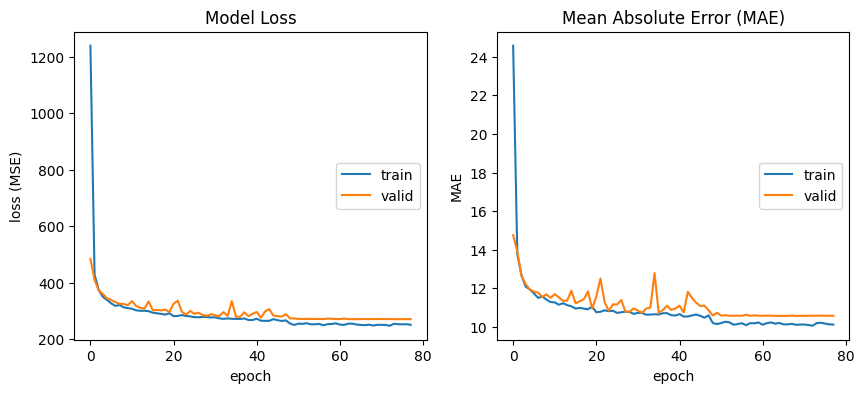

In [55]:
# Courbes d'évaluation de l'apprentissage 

train_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

train_mae = model_history.history['mean_absolute_error']
val_mae = model_history.history['val_mean_absolute_error']

plt.figure(figsize = (10, 4))

plt.subplot(121)
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Model Loss')
plt.ylabel('loss (MSE)')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')

plt.subplot(122)
plt.plot(train_mae)
plt.plot(val_mae)
plt.title('Mean Absolute Error (MAE)')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')

plt.show()


In [ ]:
# Modification des coefficients des 4 dernières couches de la partie VGG16

for layer in base_model.layers[-4:]:
    layer.trainable = True
model.compile(loss='mse',
              optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4),
              metrics=['mean_absolute_error'])

# Poursuite de l'entraînement et sauvegarde du modèle
model_history_2 = model.fit(image_train_generator,
                                epochs=100,
                                steps_per_epoch=len(image_train_generator),
                                callbacks=[model_checkpoint, early_stopping, reduce_learning_rate, time_callback],
                                validation_data=image_valid_generator,
                                validation_steps=len(image_valid_generator),
                                verbose=True)


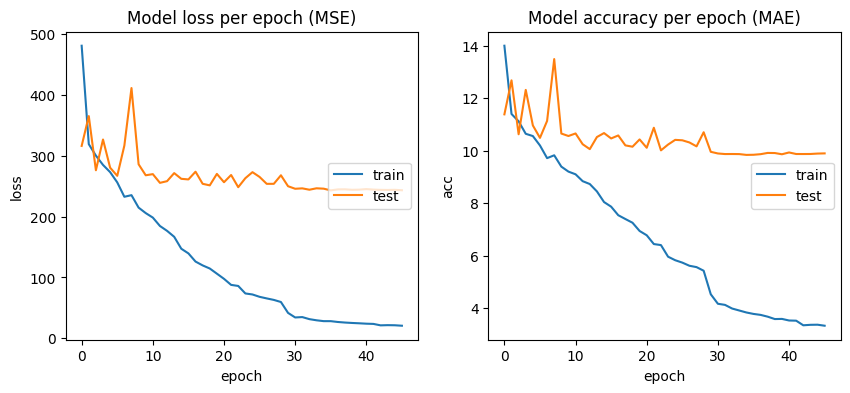

In [20]:
# Courbes d'évaluation de l'apprentissage 

train_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

train_mae = model_history.history['mean_absolute_error']
val_mae = model_history.history['val_mean_absolute_error']

plt.figure(figsize = (10, 4))

plt.subplot(121)
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Model Loss')
plt.ylabel('loss (MSE)')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')

plt.subplot(122)
plt.plot(train_mae)
plt.plot(val_mae)
plt.title('Mean Absolute Error (MAE)')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')

plt.show()


In [7]:
# Chargement du modèle
#model = load_model('models/model_vgg16_2')
model = load_model('models/model transfer2_202403020554')

2024-03-04 14:54:20.751504: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-03-04 14:54:20.751528: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-03-04 14:54:20.751532: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-03-04 14:54:20.751566: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-04 14:54:20.751582: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


2024-03-04 14:54:24.748927: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


75/75 [==============================] - 54s 712ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: 

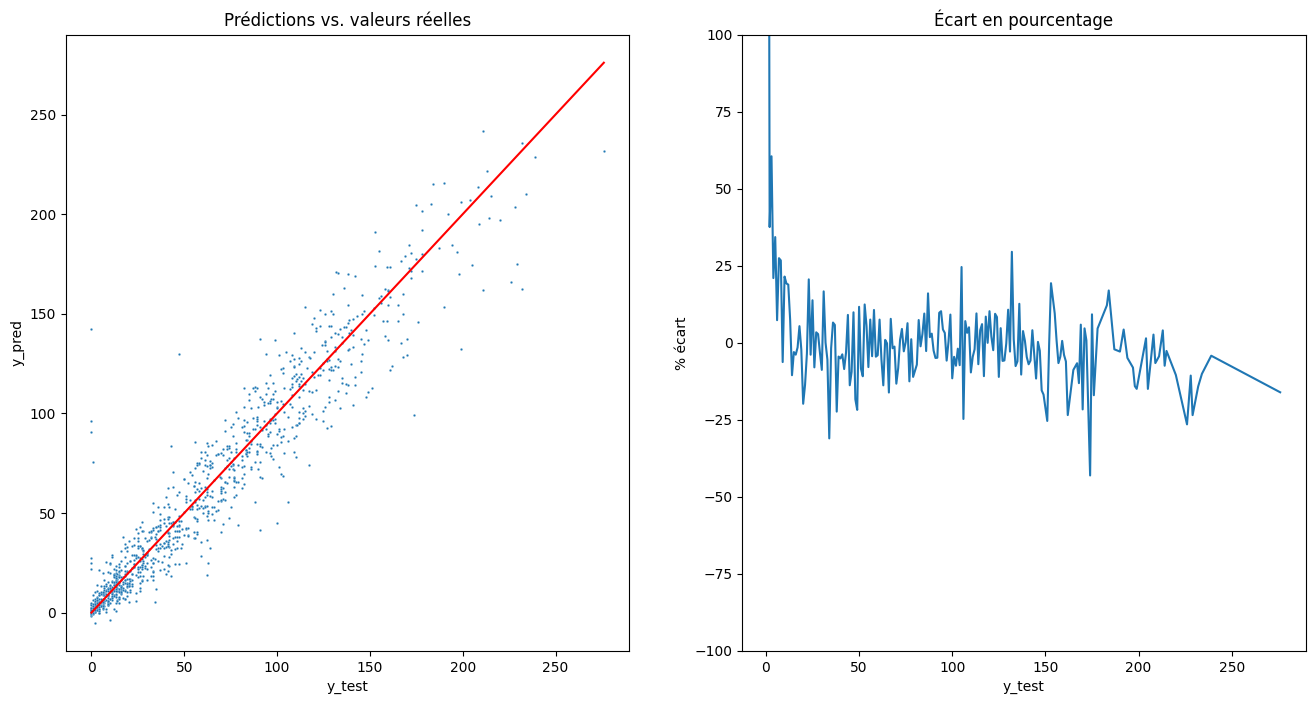

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


,y_test,y_pred,Ecart,% écart
count,1188.000000,1188.000000,1188.000000,1188.000000
mean,54.926768,54.463879,-0.462892,NaN
std,53.912490,53.209679,14.564627,NaN
min,0.000000,-5.047549,-74.993111,-inf
25%,9.000000,9.377081,-5.788338,-19.506809
50%,39.000000,37.328262,-0.100937,-0.926917
75%,91.000000,91.097290,5.196804,21.026486
max,276.000000,241.611710,142.310074,inf


In [8]:
# Calcul des prédictions y_pred et des résidus sur l'ensemble test
image_test_generator.reset()

y_pred = np.array(model.predict(x=image_test_generator, verbose=1)).flatten()
y_test = image_test_generator.labels

df_residus = pd.DataFrame(data={'y_test' : y_test, 'y_pred' : y_pred, 'Ecart' : y_pred - y_test})
df_residus['% écart'] = df_residus['Ecart'] / df_residus['y_test'] * 100

# Graphe des résidus

fig = plt.figure(figsize=(16, 8))

fig.add_subplot(121)
sns.scatterplot(data=df_residus, x='y_test', y='y_pred', s=3)
plt.plot([0, max(y_test)], [0, max(y_test)], color='red')
plt.title('Prédictions vs. valeurs réelles')
plt.xlabel('y_test')
plt.ylabel('y_pred')

fig.add_subplot(122)
sns.lineplot(data=df_residus, x='y_test', y='% écart', errorbar=None)
plt.title('Écart en pourcentage')
plt.xlabel('y_test')
plt.ylabel('% écart')
plt.ylim((-100, 100))
plt.show();

df_residus.describe()

Écart y_pred_rgb - y_test
count    1188.000000
mean       -1.229283
std        15.449834
min       -86.956001
25%        -7.604033
50%         0.339477
75%         5.056055
max       123.021492
dtype: float64

Écart y_pred_transfer - y_test
count    1188.000000
mean       -0.462892
std        14.564627
min       -74.993111
25%        -5.788338
50%        -0.100937
75%         5.196804
max       142.310074
dtype: float64

Écart y_pred_mean - y_test
count    1188.000000
mean       -0.846087
std        13.979322
min       -76.791348
25%        -5.919012
50%         0.176960
75%         4.565459
max       132.665783
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: 

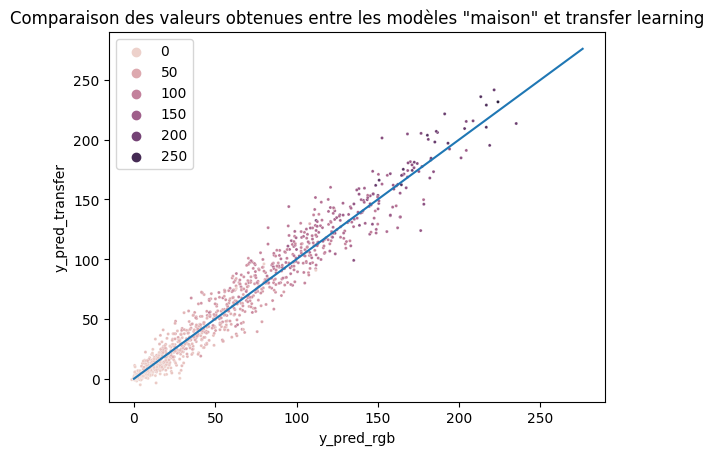

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: 

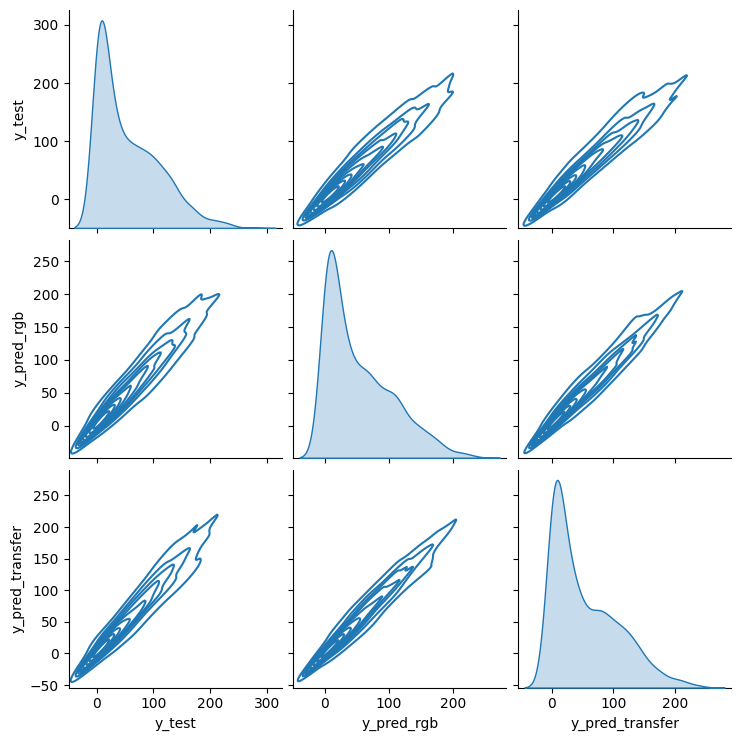

In [35]:
# Comparaison avec les résultats du modèle RGB, et la moyenne des 2 modèles

df_residus_rgb = pd.read_excel('df_residus_rgb.xlsx').rename(columns={'y_test' : 'y_test_rgb',
                                                                      'y_pred' : 'y_pred_rgb',
                                                                      'Ecart' : 'Ecart_rgb',
                                                                      '% écart' : '% écart rgb'})
df_comp_res = pd.concat([df_residus_rgb, df_residus], axis=1).rename(columns={
                                                                      'y_pred' : 'y_pred_transfer',
                                                                      'Ecart' : 'Ecart_transfer',
                                                                      '% écart' : '% écart transfer'})
df_comp_res['y_pred_mean'] = (df_comp_res['y_pred_rgb'] + df_comp_res['y_pred_transfer']) / 2

# Describe
print ('Écart y_pred_rgb - y_test')
print ((df_comp_res['y_pred_rgb'] - df_comp_res['y_test']).describe())
print ('\nÉcart y_pred_transfer - y_test')
print ((df_comp_res['y_pred_transfer'] - df_comp_res['y_test']).describe())
print ('\nÉcart y_pred_mean - y_test')
print ((df_comp_res['y_pred_mean'] - df_comp_res['y_test']).describe())

# Scatter plot
sns.scatterplot(data=df_comp_res, x='y_pred_rgb', y='y_pred_transfer', hue='y_test', s=5)
sns.lineplot(data=df_comp_res, x='y_test', y='y_test', errorbar=None)
plt.title('Comparaison des valeurs obtenues entre les modèles "maison" et transfer learning')
plt.show();

# Pair plot
sns.pairplot(data=df_comp_res, vars=['y_test', 'y_pred_rgb', 'y_pred_transfer'], kind='kde')
plt.show();

Bâtiments prédits à une tolérance de 1 : 18.939393939393938 %
Bâtiments prédits à une tolérance de 10 : 68.60269360269359 %
Test de Pearson : coeff=0.963112752886563 pvalue=0.0


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


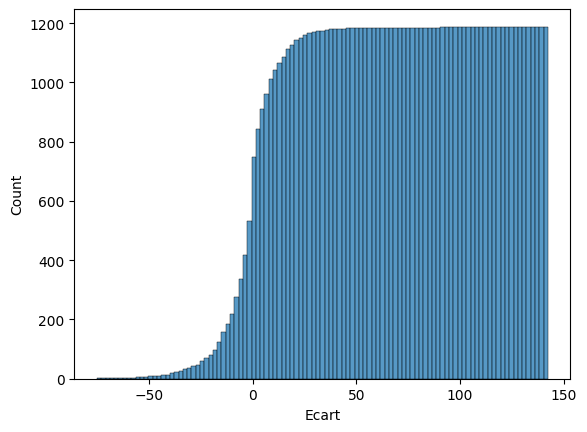

In [65]:
# Analyse des prédictions
tolerance = (lambda t : df_residus.loc[abs(df_residus['Ecart']) < t, 'Ecart'].count() / len(df_residus) * 100)

t = 1
print (f'Bâtiments prédits à une tolérance de {t} : {tolerance(t)} %')

t = 10
print (f'Bâtiments prédits à une tolérance de {t} : {tolerance(t)} %')

# Test de corrélation de Pearson
from scipy.stats import pearsonr
coeff, pvalue = pearsonr(x=df_residus['y_pred'], y=df_residus['y_test'])
print (f'Test de Pearson : {coeff=} {pvalue=}')

sns.histplot(data=df_residus, x='Ecart', cumulative=True)
plt.show();


In [76]:

# Classe de base pour l'affichage des images, masques, prédictions, carte
# Sera dérivée selon le type de modèle (régression, classification)
# Cette classe gère essentiellement l'initialisation du dataframe des méta-données des images
# ainsi que l'affichage des cartes

class SimplePlotter():
    # La classe est créée avec un dataframe des méta-données des images
    # Le constructeur crée aussi le dataframe des rectangles représentant les grandes images BDTOPO
    def __init__(self, df_meta_images):
        self.dfi = df_meta_images
        self.dfrectangles = self.getOrthoImagesRectangles(dfi)

    # getOrthoImagesRectangles() retourne un dataframe des coordonnées des images non découpées
    def getOrthoImagesRectangles(self, dfi):
        dftmp = dfi.iloc[:,:4].copy()
        dftmp['xmin'] = dftmp['xrange'].apply(lambda v : v[0])
        dftmp['xmax'] = dftmp['xrange'].apply(lambda v : v[1])
        dftmp['ymin'] = dftmp['yrange'].apply(lambda v : v[0])
        dftmp['ymax'] = dftmp['yrange'].apply(lambda v : v[1])
        ret = dftmp.groupby(['imgID']).agg({'xmin' : 'min', 'xmax' : 'max', 'ymin' : 'min', 'ymax' : 'max'}).reset_index()
        ret['width'] = ret['xmax'] - ret['xmin']
        ret['height'] = ret['ymax'] - ret['ymin']
        return ret

    # plotImagesPositionsInRectangles() prend en entrée une liste de tuples (imgID, cutID)
    def plotImagesPositionsInRectangles(self, images, ax, mapIndices=True):
        self.dfrectangles.apply(lambda r : ax.add_patch(Rectangle((r['xmin'], r['ymin']),
                                                                  r['width'], r['height'],
                                                                  edgecolor=(0.2, 0.2, 0.5, 1),
                                                                  facecolor=(0.9, 0.9, 0.9, 1), linewidth=2.0)),
                                                                  axis=1)
        if (mapIndices):
            self.dfrectangles.apply(lambda r : ax.text(r['xmin'] + r['width'] / 2,
                                                       r['ymin'] + r['height'] / 2,
                                                       int(r['imgID']),
                                                       color='darkblue'),
                                                       axis=1)
        for img in images:
            img_metadata = self.dfi[(self.dfi['imgID']==img[0]) & (self.dfi['cutID']==img[1])]
            ax.add_patch(Rectangle((img_metadata['xrange'].values[0][0], img_metadata['yrange'].values[0][0]),
                    img_metadata['xrange'].values[0][1] - img_metadata['xrange'].values[0][0],
                    img_metadata['yrange'].values[0][1] - img_metadata['yrange'].values[0][0],
                    edgecolor=(1, 0, 0, 1),
                    facecolor=(1, 0, 0, 1),
                    linewidth=2.0))
        plt.xlim(self.dfrectangles['xmin'].min(), self.dfrectangles['xmax'].max())
        plt.ylim(self.dfrectangles['ymin'].min(), self.dfrectangles['ymax'].max())


# Classe permettant d'afficher les images pour un modèle de régression
class RegressionPlotter(SimplePlotter):
    # La classe est créée avec un dataframe des méta-données des images et un dataframe des résidus
    # Attention : ces deux dataframes doivent être dans le même ordre, avec un index à jour (après reset_index())
    def __init__(self, df_meta_images, df_residus):
        super(RegressionPlotter, self).__init__(df_meta_images)
        self.dfi = pd.concat([self.dfi, df_residus], axis=1)

    # plot() prend en entrée soit imgID et cutID, soit index
    def plot(self, imgID=None, cutID=None, index=None, mapIndices=True):
        if (index != None):
            img_metadata = self.dfi.iloc[index,:]
            ortho_filename = img_metadata['filename'].split(' ')[-1]
            topo_filename = img_metadata['mask_filename'].split(' ')[-1]
            imgID, cutID = img_metadata['imgID'], img_metadata['cutID']
            real, pred = img_metadata['y_test'], int(np.round(img_metadata['y_pred']))
        else:
            img_metadata = self.dfi[(self.dfi['imgID']==imgID) & (self.dfi['cutID']==cutID)]
            ortho_filename = img_metadata['filename'].values.item()
            topo_filename = img_metadata['mask_filename'].values.item()
            index = img_metadata.index
            real, pred = img_metadata['y_test'].values.item(), int(np.round(img_metadata['y_pred']))
        fig = plt.figure(figsize=(12, 5), layout='constrained')
        # Image ortho
        ax = fig.add_subplot(1, 3, 1)
        img = cv2.imread(ortho_filename)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) 
        plt.imshow(img)
        plt.title('Image source')
        plt.axis('off')
        # Masque topo réel
        ax = fig.add_subplot(1, 3, 2)
        img = cv2.imread(topo_filename)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title('Label')
        # Emplacement global dans les rectangles (grandes images ortho)
        ax = fig.add_subplot(1, 3, 3)
        self.plotImagesPositionsInRectangles([(imgID, cutID)], ax, mapIndices=mapIndices)
        plt.axis('off')
        plt.suptitle(f'Image {imgID = }, {cutID = }    Bâtiments réels = {real}, prédits = {pred}', horizontalalignment='right')
        plt.show();

plotter = RegressionPlotter(df_test, df_residus)


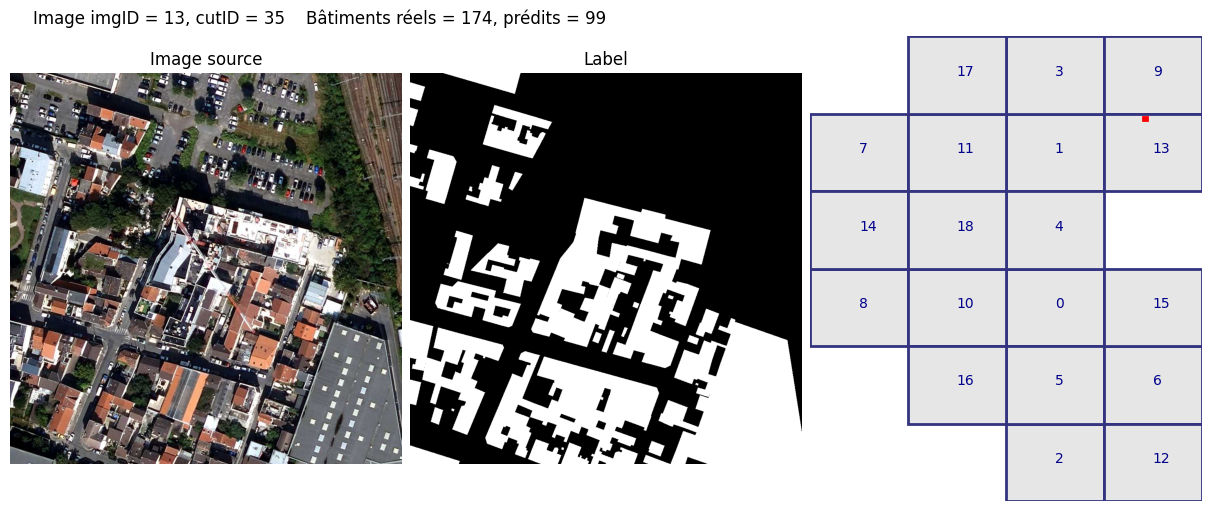

In [77]:
# Résidu le plus important en négatif
img_id = np.argmin(df_residus['Ecart'])
plotter.plot(index=img_id)


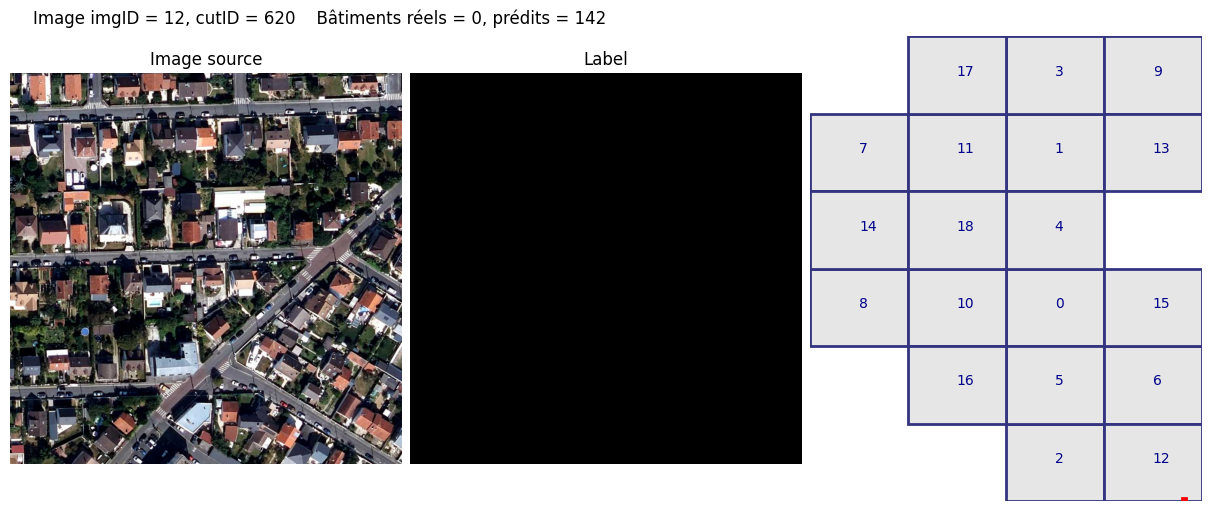

In [69]:
# Résidu le plus important en positif
img_id = np.argmax(df_residus['Ecart'])
plotter.plot(index=img_id)

      y_test      y_pred       Ecart      % écart
812        0  142.310074  142.310074          inf
1063       0   96.080627   96.080627          inf
807        0   90.670746   90.670746          inf
802       47  129.697861   82.697861   175.952895
1068       1   75.640671   74.640671  7464.067078
866       91  137.535995   46.535995    51.138457
1153      43   83.827309   40.827309    94.947229
1114     132  170.966965   38.966965    29.520428
402      115  153.431503   38.431503    33.418699
51        99  137.035355   38.035355    38.419550
1177     153  190.977188   37.977188    24.821692
1082     133  170.409134   37.409134    28.127168
999       94  130.047714   36.047714    38.348632
58       138  170.147827   32.147827    23.295527
984      109  140.381454   31.381454    28.790325
697      184  215.216721   31.216721    16.965609
864       82  112.650253   30.650253    37.378358
989      211  241.611710   30.611710    14.507919
1129     130  160.112137   30.112137    23.163182


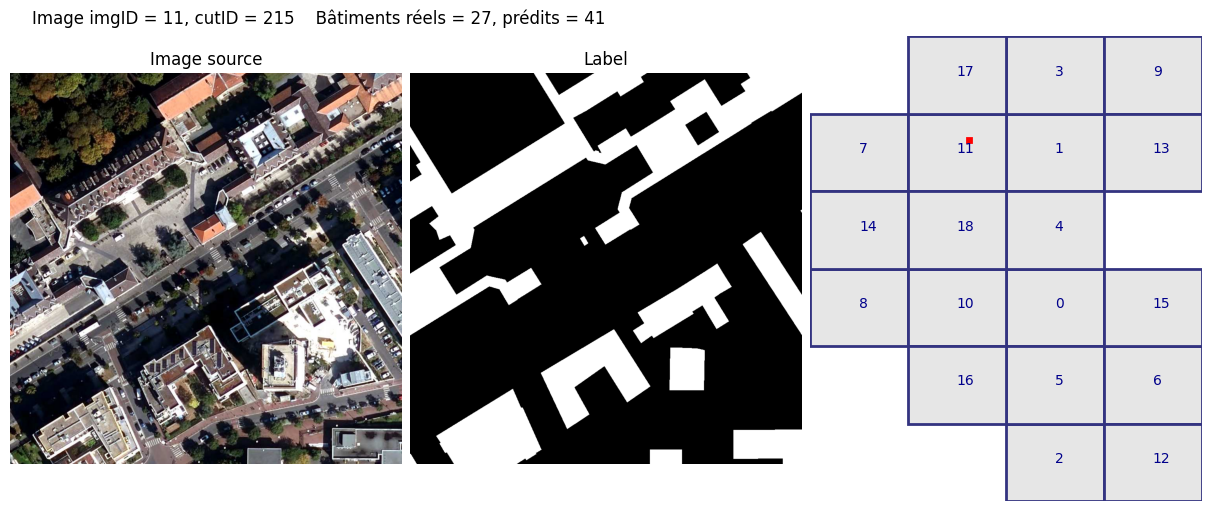

In [70]:
# Recherche d'images avec écarts importants
print (df_residus.sort_values(by='Ecart', ascending=False).head(20))
img_id = 709
plotter.plot(index=img_id)

     y_test    y_pred     Ecart     % écart
50        0  0.030097  0.030097         inf
174       0 -0.320284 -0.320284        -inf
177       0 -0.379239 -0.379239        -inf
200       1 -0.103290 -1.103290 -110.328960
211       0  0.090955  0.090955         inf
221       0 -0.690439 -0.690439        -inf
328       1 -0.212691 -1.212691 -121.269131
344       0 -0.130452 -0.130452        -inf
349       0 -0.997748 -0.997748        -inf
360       0 -0.173944 -0.173944        -inf
365       0 -0.274509 -0.274509        -inf
427       0 -0.316933 -0.316933        -inf
438       0 -0.207579 -0.207579        -inf
453       0 -0.107513 -0.107513        -inf
454       1 -0.180803 -1.180803 -118.080330


/var/folders/rp/v2y1mh854lg1zw0c5hxqdks80000gp/T/ipykernel_26792/1123272140.py:71: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  real, pred = img_metadata['y_test'].values.item(), int(np.round(img_metadata['y_pred']))


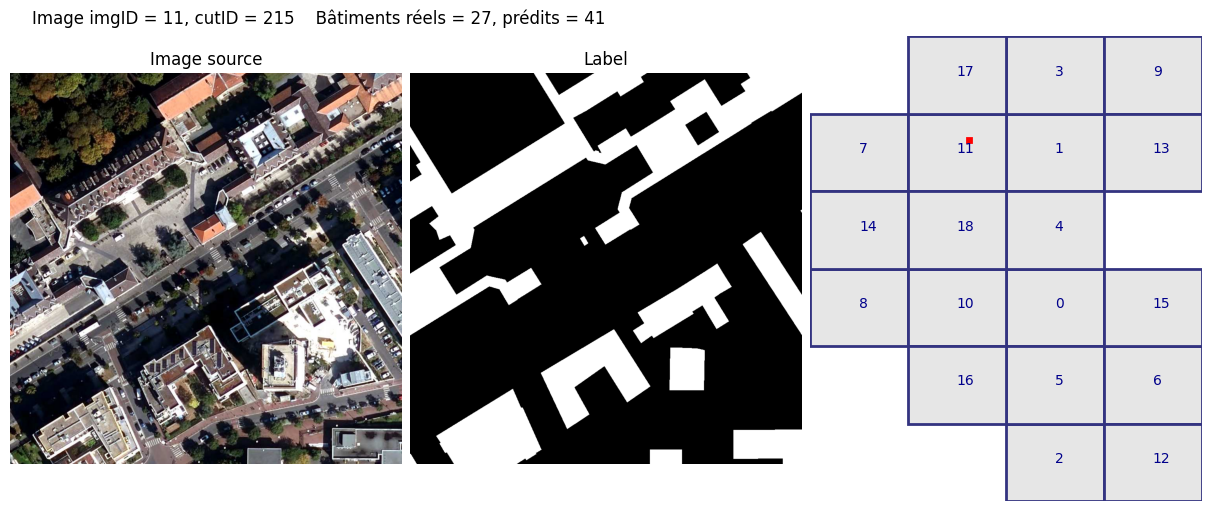

In [78]:
# Image choisie
print (df_residus[df_residus['y_pred']<0.1].head(15))
plotter.plot(imgID=11, cutID=215)